# Download pre-trained checkpoints

MAE = masked autoencoder only, PoLArMAE = masked autoencoder + energy infilling

In [1]:
!wget https://github.com/DeepLearnPhysics/PoLAr-MAE/releases/download/weights/mae_pretrain.ckpt
!wget https://github.com/DeepLearnPhysics/PoLAr-MAE/releases/download/weights/polarmae_pretrain.ckpt

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/sdf/home/y/youngsam/.wget-hsts'. HSTS will be disabled.
--2025-08-22 16:12:16--  https://github.com/DeepLearnPhysics/PoLAr-MAE/releases/download/weights/mae_pretrain.ckpt
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/927478490/2b12deb7-80eb-4280-ab3b-e47259bde380?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-22T23%3A58%3A09Z&rscd=attachment%3B+filename%3Dmae_pretrain.ckpt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-22T22%3A58%3A03Z&ske=2025-08-22T23%3A58%3A09Z&sks=b&skv=2018-11-09&sig=eAfQDswNvd0jQystQ5h%2Bm5tsXhzjCjZ%2F0zKFg40WlH4%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ

In [2]:
import torch; torch.set_grad_enabled(False);

In [3]:
from polarmae.models.ssl import PoLArMAE, PointMAE

# Load pretrained polarmae
model = PoLArMAE.load_from_checkpoint("polarmae_pretrain.ckpt").cuda()
model.eval();

INFO:polarmae.layers.grouping:[rank: 0] Using CNMS for grouping. Using `num_groups` as the K in the ball query (256)! Make sure it's not too large!
/sdf/home/y/youngsam/sw/dune/.conda/envs/polarmae/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/sdf/home/y/youngsam/sw/dune/.conda/envs/polarmae/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.
INFO:polarmae.models.ssl.polarmae:[rank: 0] ⚙️  MAE prediction: full patch reconstruction


# Dataset Initialization

In [4]:
from polarmae.datasets import PILArNetDataModule
import torch

dataset = PILArNetDataModule(
    data_path='/sdf/home/y/youngsam/data/dune/larnet/h5/DataAccessExamples/train/generic_v2*.h5',
    batch_size=24,
    num_workers=0,
    dataset_kwargs={
        'emin': 1.0e-2,                      # min energy for log transform
        'emax': 20.0,                        # max energy for log transform
        'energy_threshold': 0.13,            # remove points with energy < 0.13
        'remove_low_energy_scatters': True,  # remove low energy scatters (PID=4)
        'maxlen': -1,                        # max number of events to load
        'min_points': 1024,                  # minimum number of points in an event
    }
)
dataset.setup() # creates and initializes train/val datasets, removed low energy deposits from possible classes, etc.

INFO:polarmae.datasets.PILArNet:[rank: 0] self.emin=0.01, self.emax=20.0, self.energy_threshold=0.13, self.remove_low_energy_scatters=True
INFO:polarmae.datasets.PILArNet:[rank: 0] Building index
INFO:polarmae.datasets.PILArNet:[rank: 0] 1045215 point clouds were loaded
INFO:polarmae.datasets.PILArNet:[rank: 0] 10 files were loaded
INFO:polarmae.datasets.PILArNet:[rank: 0] self.emin=0.01, self.emax=20.0, self.energy_threshold=0.13, self.remove_low_energy_scatters=True
INFO:polarmae.datasets.PILArNet:[rank: 0] Building index
INFO:polarmae.datasets.PILArNet:[rank: 0] 10473 point clouds were loaded
INFO:polarmae.datasets.PILArNet:[rank: 0] 1 files were loaded


In [5]:
from polarmae.utils import transforms
from math import sqrt

normalize = transforms.PointcloudCenterAndNormalize(
                    center=[384, 384, 384],
                    scale_factor=1 / (768 * sqrt(3) / 2)
                )

# Inference on one batch
for batch in dataset.val_dataloader():
    points = batch['points'].cuda()

    # in the past (when this model was trained), the centering and
    # scaling was done in the data module. now it's done in the model
    # in train_transformations and val_transformations.
    # for backwards compatibility, we check if there are zero transforms
    # in val_transformations and apply normalization if so.
    if len(model.val_transformations.transforms) > 0:
        points = model.val_transformations(points)
    else:
        points = normalize(points) # scale and normalize
    lengths = batch['lengths'].cuda()

    # group & encode toks
    out = model.encoder.prepare_tokens_with_masks(points, lengths)
    masked, unmasked = out['masked'], out['unmasked']

    # run visible tokens through encoder
    encoder_output = model.encoder.transformer(out['x'], out['pos_embed'], unmasked).last_hidden_state

    # corrupt embeddings with masked tokens
    corrupted_embeddings = (
        encoder_output * unmasked.unsqueeze(-1) + 
        model.mask_token * masked.unsqueeze(-1)
    )

    # run corrupted embeddings through decoder
    decoder_output = model.decoder.transformer(corrupted_embeddings, out['pos_embed'], out['emb_mask']).last_hidden_state
    masked_output = decoder_output[masked]

    # Full patch reconstruction task
    upscaled = model.increase_dim(masked_output.transpose(0, 1)).transpose(0, 1)
    upscaled = upscaled.reshape(upscaled.shape[0], -1, model.mae_channels)
    break

`upscaled` is flattened so we need to reconstruct it to be the original shape of `groups`.

In [6]:
groups = out['groups']
centers = out['centers']
mask = out['emb_mask']
point_mask = out['point_mask']
upscaled_pts = torch.zeros_like(groups)
upscaled_pts[masked] = upscaled

group_radius = model.encoder.tokenizer.grouping.group_radius

# groups are currently normalized to the group center and scaled by group_radius, so we need to undo this to plot each group in the original coordinate space.
rescaled_groups_truth = groups.clone()
rescaled_groups_truth[:, :, :, :3] *= group_radius # undo the scaling by group_radius
rescaled_groups_truth[:, :, :, :3] = rescaled_groups_truth[:, :, :, :3] + centers[:, :, None, :3] # add back on the centers

rescaled_upscaled_pred = upscaled_pts.clone()
rescaled_upscaled_pred[:, :, :, :3] *= group_radius
rescaled_upscaled_pred[:, :, :, :3] = rescaled_upscaled_pred[:, :, :, :3] + centers[:, :, None, :3]

# Get point lengths for each event
point_lengths = point_mask.sum(-1)

In [7]:
event_idx = 2 # change me to see different events!

# Get original and upscaled (reconstructed) points.
# We are just taking the true visible groups and the reconstructed masked groups.
orig_pts = rescaled_groups_truth[event_idx][unmasked[event_idx]].cpu().numpy()
upscaled_pts = rescaled_upscaled_pred[event_idx][masked[event_idx]].cpu().numpy()

# Get point lengths for just our event
unmasked_lengths = point_lengths[event_idx][unmasked[event_idx]].cpu().numpy()
masked_lengths = point_lengths[event_idx][masked[event_idx]].cpu().numpy()

Below we plot the reconstructed points in red and the original points in black.

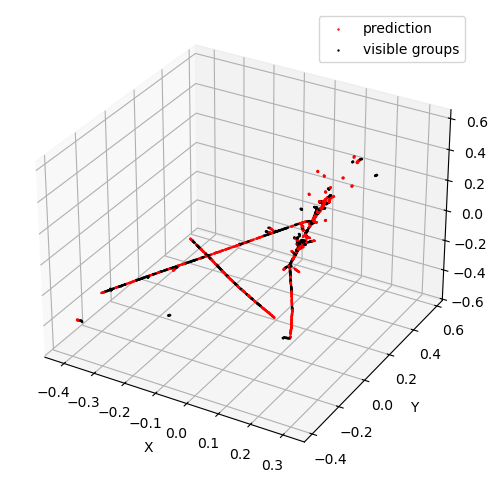

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the reconstructed points in red
for i in range(masked_lengths.shape[0]):
    pts = upscaled_pts[i, :masked_lengths[i]]
    ax.scatter(
        pts[:, 0],
        pts[:, 1],
        pts[:, 2],
        s=0.5,
        color='red',
        label=('prediction' if i == 0 else "_nolegend_")
    )

# Plot the original points in black
for i in range(unmasked_lengths.shape[0]):
    pts = orig_pts[i, :unmasked_lengths[i]]
    ax.scatter(
        pts[:, 0],
        pts[:, 1],
        pts[:, 2],
        s=0.5,
        color='black',
        label=('visible groups' if i == 0 else "_nolegend_")
    )
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()

plt.show()

Looks pretty great!

# Embedding PCA

We may also be interested in seeing the variation of the embeddings in a single event.

Since only the visible tokens went through the encoder, we can only visualize the visible ("unmasked") tokens.

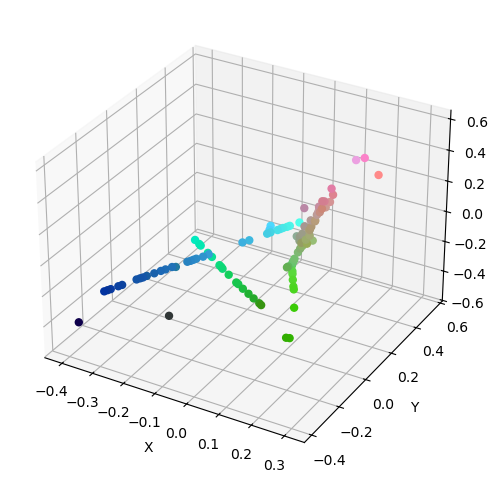

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

event_idx = 2
example_embeddings = encoder_output[event_idx][out["unmasked"][event_idx]].cpu().numpy()
centers = out["centers"]
example_centers = centers[event_idx][out["unmasked"][event_idx]].cpu().numpy()

pca = PCA(n_components=3).fit(example_embeddings)
scaled_embeddings = pca.transform(example_embeddings)
scaled_embeddings = (
    (scaled_embeddings - scaled_embeddings.min(axis=0))
    / (scaled_embeddings.max(axis=0) - scaled_embeddings.min(axis=0))
)

# Convert the scaled embeddings to RGB color tuples (values between 0 and 1) for matplotlib
colors = [
    (r, g, b)
    for r, g, b in scaled_embeddings
]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    example_centers[:, 0],
    example_centers[:, 1],
    example_centers[:, 2],
    s=25,
    color=colors,
    alpha=1.0
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

Below we encode at ALL tokens by by switching the attention mask from `unmasked` to `emb_mask` -- which is the mask for all non-padded tokens -- during the encoder forward pass.

In [10]:
encoder_output = model.encoder.transformer(out['x'], out['pos_embed'], out['emb_mask']).last_hidden_state

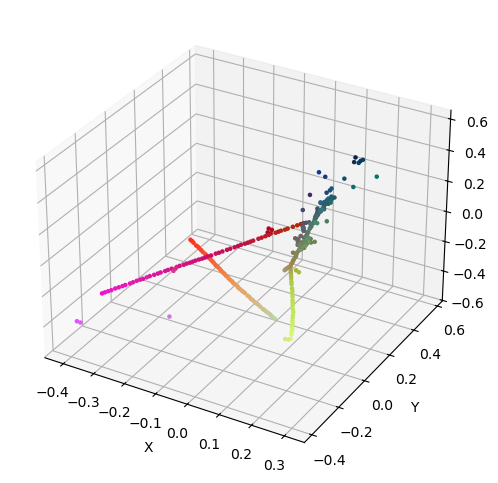

In [11]:
example_embeddings = encoder_output[event_idx][out["emb_mask"][event_idx]].cpu().numpy()
example_centers = centers[event_idx][out["emb_mask"][event_idx]].cpu().numpy()

pca = PCA(n_components=3).fit(example_embeddings)
scaled_embeddings = pca.transform(example_embeddings)
scaled_embeddings = (
    (scaled_embeddings - scaled_embeddings.min(axis=0))
    / (scaled_embeddings.max(axis=0) - scaled_embeddings.min(axis=0))
)

# Convert the scaled embeddings to RGB color tuples (values between 0 and 1) for matplotlib
colors = [
    (r, g, b)
    for r, g, b in scaled_embeddings
]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    example_centers[:, 0],
    example_centers[:, 1],
    example_centers[:, 2],
    s=5,
    color=colors,
    alpha=1.0
)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

___ 

# Regressing out spatial effects

These embeddings show quite a strong dependency on the 3D position of the points. We can attempt to disentangle this by training a simple linear model to predict the embedding from the 3D position, and then plotting the residuals. This is not a perfect disentanglement, but it is a simple and effective way to see the dependency. Formally, we are training a linear model of the form:

$$
\mathbf{e}_i = W \mathbf{p}_i + \mathbf{b} + \mathbf{\epsilon}_i
$$

where $\mathbf{e}_i$ is the embedding, $\mathbf{p}_i$ is the 3D position, $W$ is a matrix of weights, $\mathbf{b}$ is a vector of biases, and $\mathbf{\epsilon}_i = \mathbf{e}_i - (W \mathbf{p}_i + \mathbf{b})$ is a vector of residuals. We are interested in plotting the PCA projection of the residuals $\mathbf{\epsilon}_i$ to RGB space to see if there is any structure in the residuals.

In [12]:
def regress_out_spatial(embeddings, positions):
    """
    Regresses out the effect of 3D positions from high-dimensional embeddings.
    
    Parameters:
      embeddings: numpy array of shape (N, D) where D=384 in your case.
      positions: numpy array of shape (N, 3) with the (x, y, z) coordinates.
    
    Returns:
      residuals: numpy array of shape (N, D) representing the embeddings with the 
                 spatial (positional) effects removed.
    """
    N = positions.shape[0]
    # Add an intercept column (ones) to the positions.
    X = np.hstack([np.ones((N, 1)), positions])  # shape (N, 4)
    
    # Solve the least squares problem: X * beta = embeddings.
    # This computes beta with shape (4, D) that best explains the embeddings.
    beta, _, _, _ = np.linalg.lstsq(X, embeddings, rcond=None)
    
    # Predict the spatial component.
    spatial_pred = X.dot(beta)
    
    # Compute the residuals (the part of the embedding not explained by position).
    residuals = embeddings - spatial_pred

    return residuals

embeddings_flattened = encoder_output[out['emb_mask']].cpu().numpy()
centers_flattened = out['centers'][out['emb_mask']].cpu().numpy()
residuals = regress_out_spatial(embeddings_flattened, centers_flattened)
residual_embeddings = torch.zeros_like(encoder_output)
residual_embeddings[out['emb_mask']] = torch.from_numpy(residuals).to(encoder_output.device).to(encoder_output.dtype)

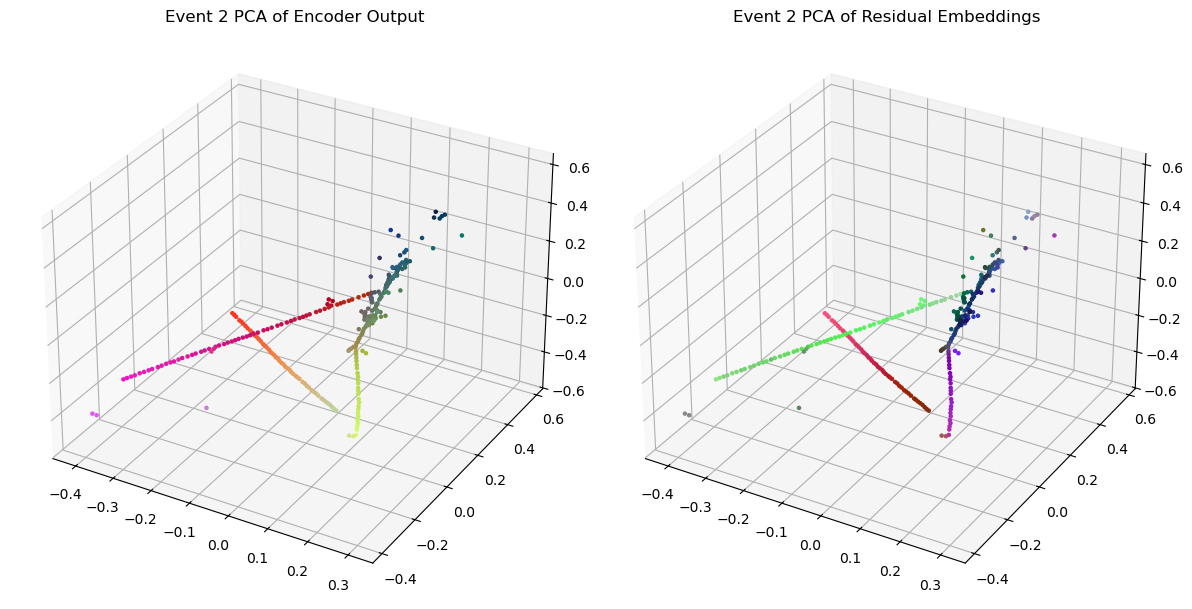

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

event_idx = 2 # change me!

# Process PCA for Encoder Output
encoder_embeddings = encoder_output[event_idx][out["emb_mask"][event_idx]].cpu().numpy()
centers = out["centers"]
encoder_centers = centers[event_idx][out["emb_mask"][event_idx]].cpu().numpy()

pca_enc = PCA(n_components=3).fit(encoder_embeddings)
scaled_embeddings_enc = pca_enc.transform(encoder_embeddings)
scaled_embeddings_enc = (
    scaled_embeddings_enc - scaled_embeddings_enc.min(axis=0)
) / (
    scaled_embeddings_enc.max(axis=0) - scaled_embeddings_enc.min(axis=0)
)

# Process PCA for Residual Embeddings
resid_embeddings = residual_embeddings[event_idx][out["emb_mask"][event_idx]].cpu().numpy()
resid_centers = centers[event_idx][out["emb_mask"][event_idx]].cpu().numpy()

pca_resid = PCA(n_components=3).fit(resid_embeddings)
scaled_embeddings_resid = pca_resid.transform(resid_embeddings)
scaled_embeddings_resid = (
    scaled_embeddings_resid - scaled_embeddings_resid.min(axis=0)
) / (
    scaled_embeddings_resid.max(axis=0) - scaled_embeddings_resid.min(axis=0)
)

# Create a figure with 2 subplots side-by-side (3D plots)
fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    subplot_kw={"projection": "3d"},
    figsize=(12, 6)
)

# Plot PCA of Encoder Output on the left
ax1.scatter(
    encoder_centers[:, 0],
    encoder_centers[:, 1],
    encoder_centers[:, 2],
    color=scaled_embeddings_enc[:],
    s=5,
    alpha=1.0,
)
ax1.set_title(f'Event {event_idx} PCA of Encoder Output')

# Plot PCA of Residual Embeddings on the right
ax2.scatter(
    resid_centers[:, 0],
    resid_centers[:, 1],
    resid_centers[:, 2],
    color=scaled_embeddings_resid[:],
    s=5,
    alpha=1.0,
)
ax2.set_title(f'Event {event_idx} PCA of Residual Embeddings')

plt.tight_layout()
plt.show()


Here we see that the residuals seem to contain much more semantic structure than the original embeddings, which is great! It is particularly exciting to see a large difference in embedding structure near the vertex on the right side (where different particle trajectories meet at one single point).